In [61]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [62]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)

In [63]:
# Add lagged returns as features
return_1d['Nifty_Auto_1d_return'] = return_1d['Nifty_Auto_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_Auto_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_Auto_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_Auto_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_Auto_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_Auto_1d_return'] >= lower_bound) & (return_1d['Nifty_Auto_1d_return'] <= upper_bound)]
np.random.seed(42)

In [64]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
13-09-11               -0.95               -0.36               0.31   
14-09-11              -13.25                2.14               0.48   
15-09-11               -0.13                0.31               0.28   
19-09-11               -7.11               -2.41              -2.72   
20-09-11               -3.09               -1.07              -0.83   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
13-09-11              0.35            -0.30                1.97   
14-09-11              0.07            -2.42               -0.68   
15-09-11             -0.16             4.74                2.96   
19-09-11             -1.62             0.01               13.07   
20-09-11              1.39            -1.47               -1.08   

          Gold_1d_

In [65]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.head().to_string(index=False))

Statistics of the cleaned data:
 Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  Inr_Usd_1d_return  Dollar_Index_1d_return  Bank_Nifty_1d_return  Nifty_IT_1d_return  Nifty_Auto_1d_return  Nifty_Metal_1d_return  Nifty_FMGC_1d_return  Nifty_Energy_1d_return  NIFTY_FIN_SERVICE_1d_return  Nifty_Infra_1d_return  Nifty_CMDT_1d_return  Nifty_Consumer_1d_return  Nifty_50_1d_return_lag1  return_squared  return_lag_interaction
              -0.95               -0.36               0.31              0.35            -0.30                1.97           -1.37               0.01                   -2.73                 -0.80               -1.27                  0.42                   0.03                 -0.86                   -1.16                         0.42                  -0.88                 -0.26                      0.88                    -0.53          0.1764                 -0.2226
             -13.25       

In [66]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_Auto_1d_return'].sort_values())
nifty_corr_1d

,Nifty_Auto_1d_return
return_squared,-0.571780
Gold_1d_return,-0.057530
NASDAQ_1d_return,-0.056136
return_lag_interaction,-0.047065
BRENT_1d_return,-0.039430
Nifty_Consumer_1d_return,-0.024245
Nifty_50_1d_return,-0.023620
Dow_Jons_1d_return,-0.022495
Nifty_Energy_1d_return,-0.010355
Dollar_Index_1d_return,-0.006844


<Axes: >

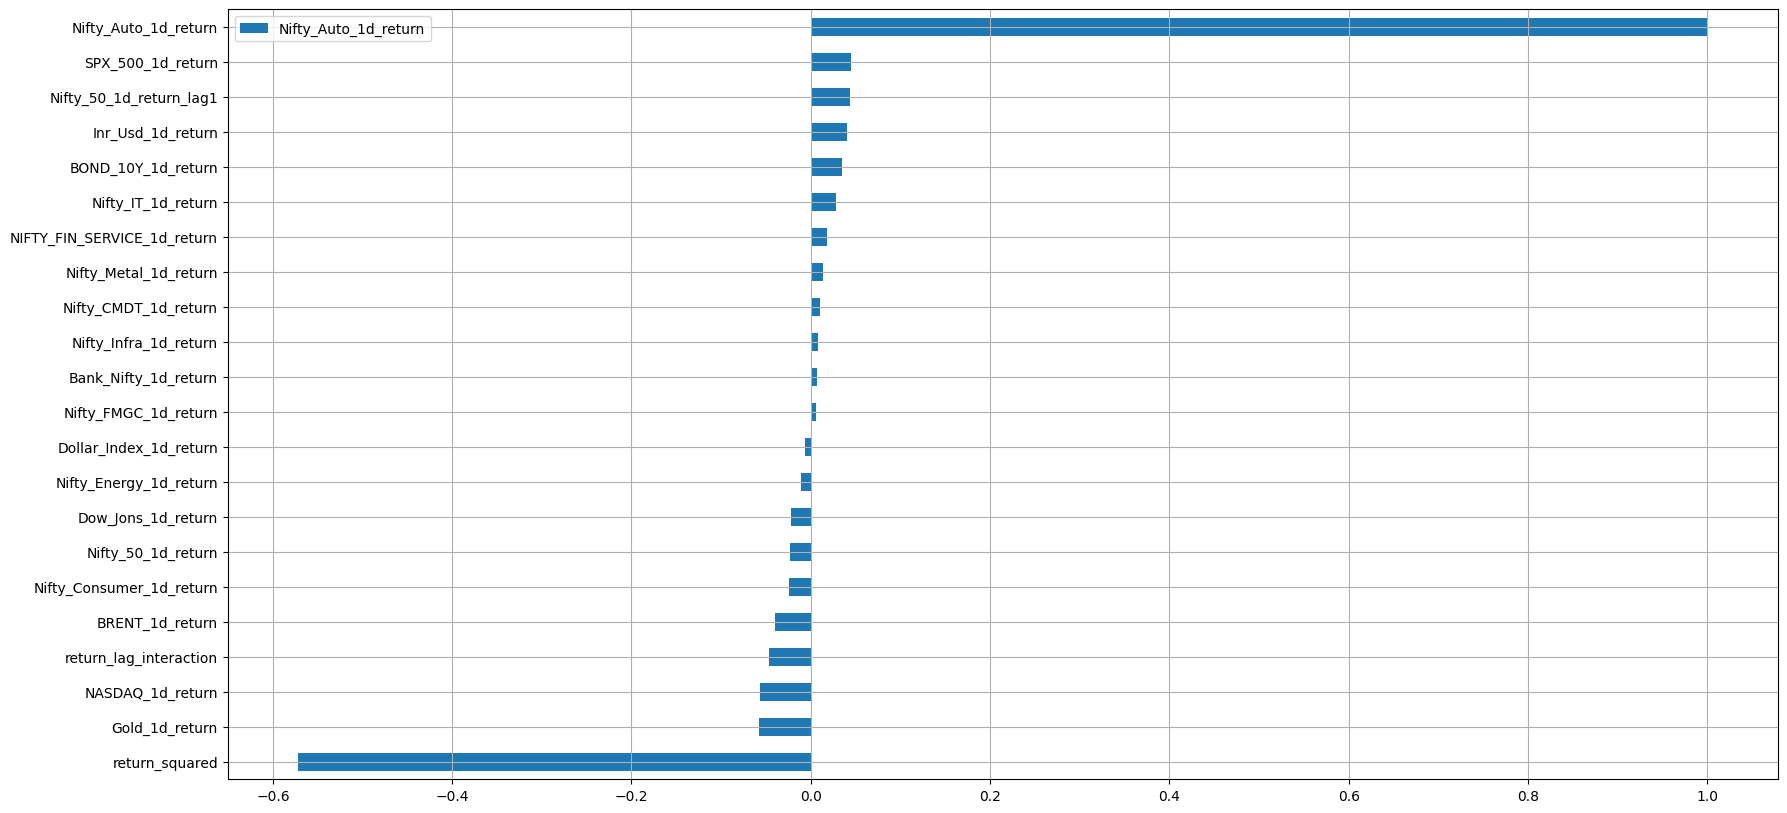

In [67]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [68]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k=10)
X = return_1d.drop(columns='Nifty_Auto_1d_return')
y = return_1d['Nifty_Auto_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Dow_Jons_1d_return', 'SPX_500_1d_return', 'NASDAQ_1d_return',
       'Nifty_Energy_1d_return', 'NIFTY_FIN_SERVICE_1d_return',
       'Nifty_Infra_1d_return', 'Nifty_Consumer_1d_return',
       'Nifty_50_1d_return_lag1', 'return_squared', 'return_lag_interaction'],
      dtype='object')


In [69]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_Auto_1d_return')
y = return_1d['Nifty_Auto_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 6.64809531e-02 -3.87227552e-02  8.11006896e-04  2.82520481e-02
  -3.05489722e-02  6.49133351e-03  1.30575358e-01  1.72804498e-02
  -5.04630634e-01 -2.52909953e-02]
 [ 2.10356315e-02  1.55556443e+00 -3.91292168e-01 -8.18263613e-03
   3.76475464e-02 -1.66929337e-01 -6.00307655e-02  2.43295385e-02
  -2.94797742e-01 -2.71455784e-02]
 [-2.74344599e-02 -4.54868661e-01  1.22558486e-01  3.65272877e-01
  -3.14330011e-02  8.63561162e-02 -1.10835738e-02 -4.19483202e+00
  -4.72522210e-01  1.29778596e+00]
 [ 1.57238407e-02 -3.10622459e-02  1.11420593e-02  8.29972101e-03
  -4.65877830e-02  3.00704598e-02 -4.17338200e-03  1.48837596e-02
   1.63579875e+00 -1.67505038e-02]
 [ 1.45434427e-02 -2.70066821e-02  1.95658405e-02  1.74424531e-01
  -2.10772335e-02  1.62417814e-01  2.46190837e-02  4.39260051e-02
  -6.53023622e-01 -2.51973667e-02]]
Date
19-04-23   -0.89
20-04-23   -1.28
25-04-23   -0.96
26-04-23   -3.07
28-04-23    0.44
Name: Nifty_Auto_1d_return, dtype: float32


Data Cleaning And Transformation Completed

Model Building for Features Importance

In [70]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [72]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [73]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [74]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.3173
R2: 0.8403

For RFR:
MSE: 0.0644
R2: 0.9676

For ETR:
MSE: 0.5287
R2: 0.7338

For GBR:
MSE: 0.1423
R2: 0.9284

For XGBR:
MSE: 0.0378
R2: 0.9810



In [75]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.0378.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.0378.

In [76]:
y_pred = etr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
05-03-20,-1.36,-1.2478
04-01-13,-1.07,-1.0280
08-03-23,1.53,0.2866
08-05-14,-3.66,-3.6632
09-01-23,-1.20,-1.0170
...,...,...
15-07-19,-0.98,-0.9838
16-12-22,0.28,-0.0598
17-12-19,-1.61,-1.5382


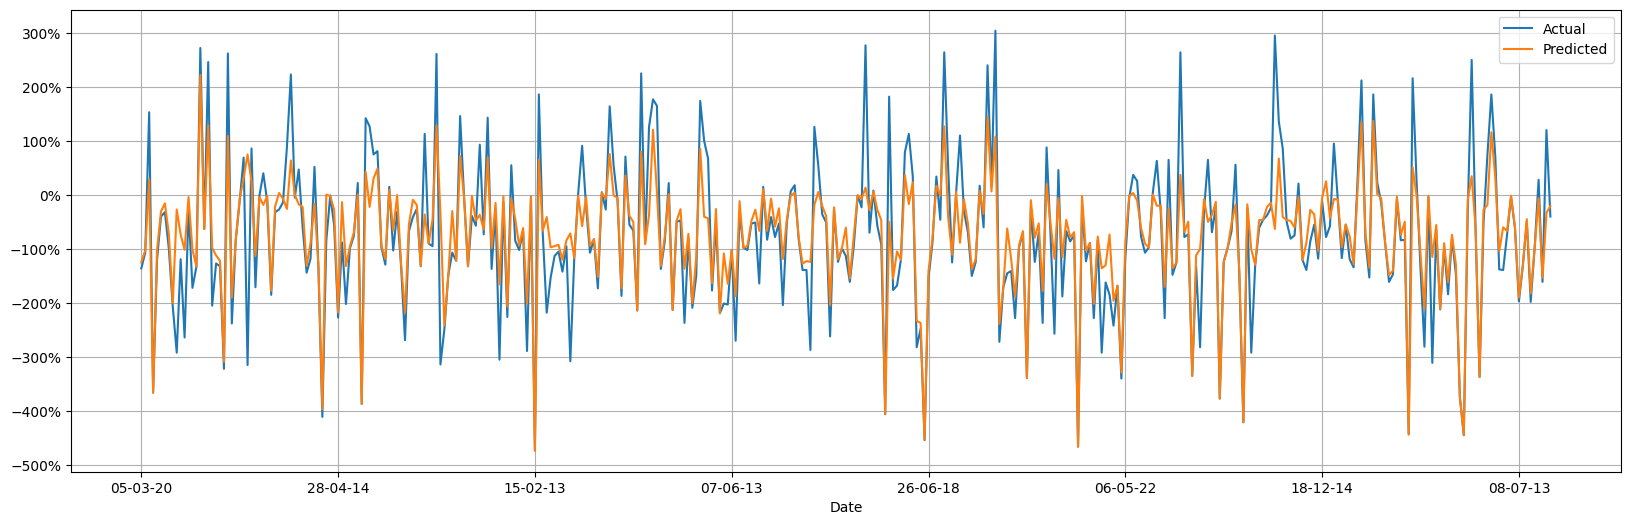

In [77]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_14684\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_Auto_1d_return', ylabel='Density'>

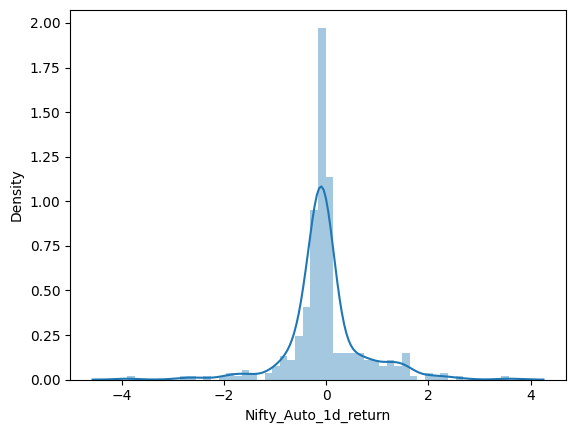

In [78]:
sns.distplot(y_test-y_pred)

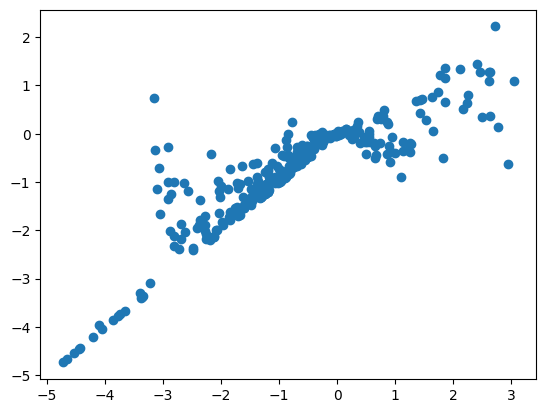

In [79]:
plt.scatter(y_test,y_pred)
